In [2]:
import calour as ca 
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from calour.training import plot_scatter
import pickle
from os.path import exists

/home/liuxuan/.local/lib/python3.8/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/liuxuan/.local/lib/python3.8/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [3]:
pd.set_option('max_colwidth',500)
pd.set_option('max_rows',500)

# loading data

In [4]:
tab = ca.read_amplicon('conqur-adjusted-table-rarefied17794.biom',
                       'metadata.txt',
                       normalize=100,min_reads=None)
tab

AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 1059 samples, 4192 features

## filtering

In [5]:
# discard samples without age information
tab = tab.filter_samples('age', np.nan, negate=True)
tab

AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 873 samples, 4192 features

In [6]:
tab.sample_metadata.pivot_table(values='_sample_id',index='project_ID',columns='diagnose',aggfunc='count')

diagnose,Healthy_control,OPMD,OSCC
project_ID,,,
OEP000837,NaN,NaN,31.0
PRJEB37501,NaN,28.0,45.0
PRJEB39064,25.0,21.0,27.0
PRJNA386665,127.0,123.0,124.0
PRJNA412445,NaN,NaN,16.0
PRJNA421234,NaN,NaN,14.0
PRJNA700849,8.0,NaN,2.0
PRJNA751046,9.0,NaN,9.0
PRJNA756784,39.0,NaN,19.0


In [7]:
# filter projects that contains both healthy and OSCC samples
tab_f = tab.filter_samples(
    'diagnose', ['Healthy_control','OSCC']).filter_abundance(0.0001)
tab_f

AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 701 samples, 3524 features

In [8]:
df = tab_f.sample_metadata.pivot_table(values='_sample_id',index='project_ID',columns='diagnose',aggfunc='count')
df['total_samples'] = df.sum(axis=1)
df

diagnose,Healthy_control,OSCC,total_samples
project_ID,,,
OEP000837,NaN,31.0,31.0
PRJEB37501,NaN,45.0,45.0
PRJEB39064,25.0,27.0,52.0
PRJNA386665,127.0,124.0,251.0
PRJNA412445,NaN,16.0,16.0
PRJNA421234,NaN,14.0,14.0
PRJNA700849,8.0,2.0,10.0
PRJNA751046,9.0,9.0,18.0
PRJNA756784,39.0,19.0,58.0


## adding age group

In [9]:
tab_f.sample_metadata['age_group_5y'] = [str(i)[0] for i in tab_f.sample_metadata['age']]
tab_f.sample_metadata['age_group_5y'].value_counts().sort_index()

2     17
3     69
4    139
5    202
6    193
7     66
8     13
9      2
Name: age_group_5y, dtype: int64

In [10]:
tab_f.sample_metadata['foo'] = ['<5' if int(str(i)[1]) < 5 else '>=5' for i in tab_f.sample_metadata['age']]
tab_f.sample_metadata['foo'].value_counts(dropna=False)

<5     370
>=5    331
Name: foo, dtype: int64

In [11]:
tab_f.sample_metadata['age_group_5y'] = tab_f.sample_metadata['age_group_5y'] + tab_f.sample_metadata['foo']
tab_f.sample_metadata['age_group_5y'].value_counts(dropna=False).sort_index()

2<5      11
2>=5      6
3<5      25
3>=5     44
4<5      68
4>=5     71
5<5      90
5>=5    112
6<5     133
6>=5     60
7<5      35
7>=5     31
8<5       6
8>=5      7
9<5       2
Name: age_group_5y, dtype: int64

In [12]:
tab_f.sample_metadata['age_group_5y'] = tab_f.sample_metadata['age_group_5y'].replace({'2<5': '3<5', '2>=5': '3<5',
                                                                                       '8<5': '7>=5', '8>=5': '7>=5', 
                                                                                       '9<5': '7>=5'})
tab_f.sample_metadata['age_group_5y'].value_counts().sort_index()

3<5      42
3>=5     44
4<5      68
4>=5     71
5<5      90
5>=5    112
6<5     133
6>=5     60
7<5      35
7>=5     46
Name: age_group_5y, dtype: int64

In [14]:
tab_f.sample_metadata.drop(columns=['foo'], inplace=True)

## age distribution

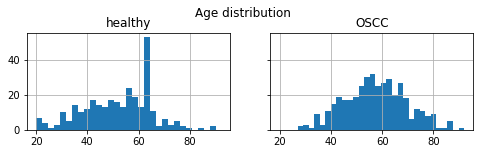

In [17]:
# age distribution in treatments in all samples
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 2), 
                         sharex=True, sharey=True)
tab_f.filter_samples('diagnose', 'Healthy_control').sample_metadata['age'].hist(
    bins=30, ax=axes[0])
axes[0].set_title('healthy')
tab_f.filter_samples('diagnose', 'OSCC').sample_metadata['age'].hist(
    bins=30, ax=axes[1])
axes[1].set_title('OSCC')
plt.suptitle('Age distribution')
plt.subplots_adjust(top=0.8)

# age prediction

In [18]:
tab_f_hc = tab_f.filter_samples('diagnose', 'Healthy_control')
tab_f_oscc = tab_f.filter_samples('diagnose', 'OSCC')
tab_f_hc, tab_f_oscc

(AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 298 samples, 3524 features,
 AmpliconExperiment ("conqur-adjusted-table-rarefied17794.biom") with 403 samples, 3524 features)

## model selection

In [19]:
# Import the library
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import model_selection, metrics

ModuleNotFoundError: No module named 'lightgbm'

In [278]:
random_state = 1234

In [279]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    tab_f_hc.data, 
    tab_f_hc.sample_metadata['age'], 
    test_size=0.1,
    stratify=tab_f_hc.sample_metadata['age_group_5y'], 
    random_state=random_state)

In [19]:
# Loading all Models
models = []
models.append(('RF', RandomForestRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('lightGBM', LGBMRegressor()))
models.append(('catBoost', CatBoostRegressor()))
models.append(('XGBoost', XGBRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))

In [21]:
# Evaluating the models
results = []
for name, model in models:
    cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_state)
    mae = model_selection.cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error',
                                          cv=cv, n_jobs=-1, error_score='raise')
    r2 = model_selection.cross_val_score(model, X_train, y_train, scoring='r2', 
                                         cv=cv, n_jobs=-1, error_score='raise')
    results.append([name, mae, r2])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7004
[LightGBM] [Info] Number of data points in the train set: 214, number of used features: 460
[LightGBM] [Info] Start training from score 51.766355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

TBB Warning: The number of workers is currently limited to 0. The request for 27 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



Learning rate set to 0.032091
0:	learn: 13.3088615	total: 97ms	remaining: 1m 36s
1:	learn: 13.2168610	total: 142ms	remaining: 1m 10s
2:	learn: 13.1370721	total: 186ms	remaining: 1m 1s
3:	learn: 13.0644935	total: 231ms	remaining: 57.5s
4:	learn: 12.9711489	total: 275ms	remaining: 54.7s
5:	learn: 12.9014707	total: 319ms	remaining: 52.8s
6:	learn: 12.8506151	total: 361ms	remaining: 51.3s
7:	learn: 12.7526320	total: 404ms	remaining: 50.1s
8:	learn: 12.6824685	total: 447ms	remaining: 49.3s
9:	learn: 12.6167278	total: 491ms	remaining: 48.6s
10:	learn: 12.5496214	total: 536ms	remaining: 48.2s
11:	learn: 12.4898304	total: 579ms	remaining: 47.7s
12:	learn: 12.4446336	total: 626ms	remaining: 47.5s
13:	learn: 12.3802966	total: 654ms	remaining: 46.1s
14:	learn: 12.3202136	total: 700ms	remaining: 46s
15:	learn: 12.2629273	total: 744ms	remaining: 45.8s
16:	learn: 12.2028193	total: 788ms	remaining: 45.6s
17:	learn: 12.1509625	total: 831ms	remaining: 45.4s
18:	learn: 12.0998908	total: 875ms	remaining:

In [22]:
df = pd.DataFrame(results, columns = ['model', 'neg_mean_absolute_error', 'r2'])

df['mean_neg_mean_absolute_error'] = [np.mean(i) for i in df['neg_mean_absolute_error']]
df['mean_r2'] = [np.mean(i) for i in df['r2']]

df.sort_values('mean_neg_mean_absolute_error', ascending=False, inplace=True)

df

,model,neg_mean_absolute_error,r2,mean_neg_mean_absolute_error,mean_r2
0,RF,"[-10.317777777777778, -10.023148148148149, -9.063148148148148, -8.731698113207546, -9.570188679245284, -8.891111111111112, -10.41222222222222, -8.834259259259259, -8.232641509433963, -10.930566037735852, -8.688148148148148, -9.523888888888886, -9.265185185185185, -10.691886792452829, -9.039622641509432]","[0.05616112759866865, 0.22098010142954383, 0.16505786343617346, 0.23625926563957855, 0.29207261601314116, 0.25377573583692115, 0.13596592990745937, 0.29123013543211973, 0.07571163727170527, 0.15707241530814797, 0.24687718037257145, 0.1579407421913246, 0.11726439699969238, 0.13481507186160413, 0.2925032755267305]",-9.481033,0.188912
4,XGBoost,"[-10.321831138045699, -8.40227331938567, -8.921519385443794, -8.209630138469192, -10.241546414933115, -10.435336960686577, -10.79032184459545, -8.677299958688241, -7.733736146171138, -11.203604896113557, -8.989317152235243, -10.213739183213976, -9.831242561340332, -10.834184106790795, -9.386693414652123]","[0.019844589200097573, 0.43337412612880366, 0.18981620813868194, 0.22993612222010296, 0.18361030478048868, 0.09281329402758509, 0.09516715041394219, 0.34706556760352314, 0.0794990612132579, -0.051343865238415276, 0.17964691946842137, 0.019171058660172657, 0.04327331499174902, 0.0747195876523844, 0.19754142371644545]",-9.612818,0.142276
3,catBoost,"[-9.963595341367368, -10.199740238448296, -9.071525184938578, -9.239239527335688, -10.32379023447075, -9.549595568802943, -10.125139035436426, -9.468957026916106, -8.864452795055518, -10.705320011700968, -8.654004811376238, -9.901285141980907, -9.363406721271623, -10.891316158302333, -8.819844072134373]","[0.09470218207530656, 0.21808398845139143, 0.12037867285552106, 0.1636297376970155, 0.2028688937465577, 0.17890651532887736, 0.1443891095115628, 0.20228834305513443, -0.05202338755988278, 0.13924875608029286, 0.22829532612884917, 0.08582316215765962, 0.10212517099841989, 0.10607398453933958, 0.2881111200002068]",-9.676081,0.148193
1,GB,"[-10.262050485633775, -10.845689262929945, -9.317776113518333, -8.730137170415396, -10.219931309100174, -9.96073502552192, -10.821750593568643, -10.071434883947845, -8.76548672979527, -10.429734144764852, -8.590468975363425, -10.334266073965656, -9.538231480495712, -10.670008391694799, -9.089949782545885]","[0.05697313659232328, 0.1209203646296213, 0.06585307137242835, 0.20185023379467604, 0.18692686114228407, 0.10191622229805197, 0.09201337416365618, 0.19955476228755198, -0.13881751553047272, 0.1441934182051483, 0.20415327114380655, 0.020528692425587525, 0.025073696859736816, 0.08587800879234042, 0.28919258905227063]",-9.843177,0.110414
5,AdaBoost,"[-10.21582607289238, -10.45859157640691, -9.544080132769325, -9.131791186560378, -10.847561359630173, -9.911634589417936, -11.607602814937552, -10.584509407014819, -8.37121110338191, -10.662815399451691, -9.077607700662853, -10.445781785775647, -9.159381137091893, -11.33234763973716, -10.165501074231338]","[0.12779448193103404, 0.19769480699315445, 0.00879263328392188, 0.1608738135543194, 0.2742399475811641, 0.21014830588898703, 0.07332934900030719, 0.18349396211975066, -0.014943559184479316, 0.1834578080831505, 0.2174746004616348, 0.015228825150110592, 0.06594570936863076, 0.08564015675346548, 0.27067930387051786]",-10.101083,0.137323
2,lightGBM,"[-10.377187230001457, -10.64051697206702, -9.934562539606894, -9.309880927938053, -10.121696424221257, -9.778083961947582, -10.019748383311947, -9.63647827327204, -8.61623046482201, -11.342787195468004, -8.732691156476207, -11.213279863185388, -10.533416532779675, -11.469100936874339, -10.052149937090315]","[0.0164896222740889, 0.22306512528311817, -0.06933915045125927, 0.1441814668648047, 0.21056898597418283, 0.21592828689334598, 0.20469910294828297, 0.16252744446953982, -0.062418445490761476, 0.09532823257443623, 0.23595112068245194, -0.08098419394461165, -0.04484320595860947, 0.04182377838577167, 0.19689745889783972]",-10.118521,0.099325


Based on the mean(neg_mean_absolute_error), we used the Random forest model to predict age .

## hyperparameter tuning

In [23]:
rf = RandomForestRegressor(random_state=random_state)

In [24]:
# model hyperparameters by random search method
params = {
    'n_estimators': [1000],
    'criterion': ['mae'],
    'max_depth': [None, 5, 10, 20, 50], # The maximum depth of the tree
    'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node, default=2.
    'min_samples_leaf': [1, 2, 5, 10], # The minimum number of samples required to be at a leaf node, default=1.
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None], # If None then unlimited number of leaf nodes.
    'bootstrap': [True],
}

randomized_search = model_selection.RandomizedSearchCV(estimator=rf,
                                                       param_distributions=params,
                                                       cv = 5,
                                                       scoring='neg_mean_squared_error',
                                                       verbose=1)

randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1234),
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['mae'],
                                        'max_depth': [None, 5, 10, 20, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1000]},
                   scoring='neg_mean_squared_error', verbose=1)

In [25]:
randomized_search.best_estimator_

RandomForestRegressor(criterion='mae', max_features='sqrt', min_samples_leaf=2,
                      n_estimators=1000, random_state=1234)

Text(0, 0.5, 'Predicted age')

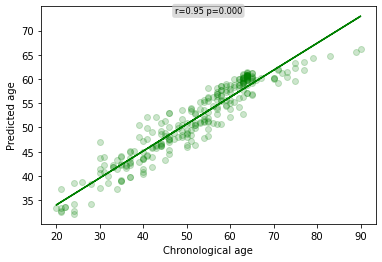

In [280]:
yhat_train = randomized_search.predict(X_train) 
fig, ax = plt.subplots()
ca.plotting.plot_scatter(y_train, yhat_train, ax=ax)
ax.set_xlabel('Chronological age')
ax.set_ylabel('Predicted age')
# r is spearman corr coef

In [281]:
np.corrcoef(yhat_train, y_train) # pearson

array([[1.        , 0.94868407],
       [0.94868407, 1.        ]])

In [282]:
print('MAE=%.3f' % round(metrics.mean_absolute_error(y_train, yhat_train), 3))
print('R2=%.3f' % round(metrics.r2_score(y_train, yhat_train), 3))

MAE=4.972
R2=0.769


previous study showed that GAI (pred - true) is positively correlated with chronological age.  
We also tested it on our data:

In [283]:
df = pd.DataFrame({'pred': yhat_train, 
                   'true': y_train})
df['delta'] = df['pred'] - df['true']

df.head()

,pred,true,delta
sample-id,,,
ERR4296619,54.2315,62.0,-7.7685
SRR21105684,55.3085,53.0,2.3085
SRR15560940,38.4595,32.0,6.4595
SRR5559578,43.3480,34.0,9.3480
SRR21105632,55.6535,54.0,1.6535


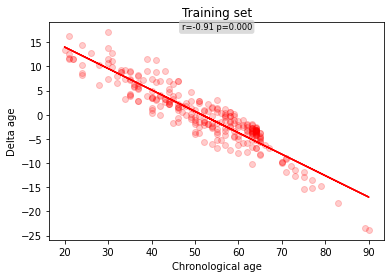

In [287]:
ca.plotting.plot_scatter(df['true'], df['delta'])
plt.xlabel('Chronological age')
plt.ylabel('Delta age')
plt.title('Training set')

In [116]:
df = df.join(tab_f.sample_metadata['age_group_5y'])

In [117]:
delta_mean = df.groupby('age_group_5y')['delta'].mean()
delta_mean.name = 'delta_mean'

In [118]:
df = pd.merge(df, delta_mean, how='left', left_on='age_group_5y', right_index=True)

In [119]:
df.head()

,pred,true,delta,age_group_5y,delta_mean
sample-id,,,,,
ERR4296619,54.2315,62.0,-7.7685,6<5,-3.831559
SRR21105684,55.3085,53.0,2.3085,5<5,-1.067561
SRR15560940,38.4595,32.0,6.4595,3<5,10.496683
SRR5559578,43.3480,34.0,9.3480,3<5,10.496683
SRR21105632,55.6535,54.0,1.6535,5<5,-1.067561


In [120]:
df['pred_adj'] = df['pred'] - df['delta_mean']
df['delta_adj'] = df['pred_adj'] - df['true']
df.groupby('age_group_5y')['delta_adj'].mean()

age_group_5y
3<5     3.079019e-15
3>=5   -6.459479e-16
4<5    -2.368476e-16
4>=5    2.842171e-15
5<5     3.229740e-15
5>=5    1.639714e-15
6<5    -1.204310e-16
6>=5    2.960595e-15
7<5     3.157968e-15
7>=5   -1.578984e-15
Name: delta_adj, dtype: float64

<AxesSubplot:>

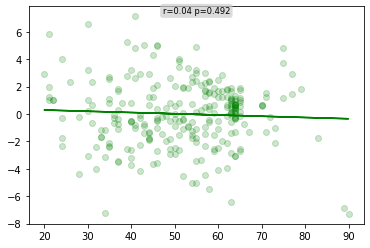

In [121]:
ca.plotting.plot_scatter(df['true'], df['delta_adj'])

Text(0, 0.5, 'Predicted age')

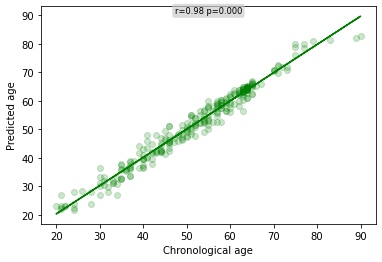

In [122]:
fig, ax = plt.subplots()
ca.plotting.plot_scatter(df['true'], df['pred_adj'], ax=ax)
ax.set_xlabel('Chronological age')
ax.set_ylabel('Predicted age')

In [123]:
np.corrcoef(df['true'], df['pred_adj']) # pearson

array([[1.        , 0.98470752],
       [0.98470752, 1.        ]])

In [124]:
print('MAE=%.3f' % round(metrics.mean_absolute_error(df['true'], df['pred_adj']), 3))
print('R2=%.3f' % round(metrics.r2_score(df['true'], df['pred_adj']), 3))

MAE=1.815
R2=0.969


## prediction

In [208]:
randomized_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_leaf_nodes': None,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'mae',
 'bootstrap': True}

In [209]:
rf = RandomForestRegressor(n_estimators=1000,
                           min_samples_split=2,
                           min_samples_leaf=2,
                           max_leaf_nodes=None,
                           max_features='sqrt',
                           max_depth=None,
                           criterion='mae',
                           bootstrap=True,
                           random_state=random_state)

In [210]:
rskf = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_state)

In [211]:
# use healthy samples to predict OSCC samples
field = 'age'
res_hc_train = []
res_hc_test = []
res_oscc = []
for i, (train_index, test_index) in enumerate(rskf.split(tab_f_hc.data,
                                                         tab_f_hc.sample_metadata['age_group_5y'])):
    X_train = tab_f_hc.data[train_index]
    y_train = tab_f_hc.sample_metadata[field][train_index]
    
    rf.fit(X_train, y_train)
    
    # calculate delta to adjust predited value
    df = pd.DataFrame({'Y_PRED': rf.predict(X_train), 
                       'Y_TRUE': y_train},
                      index=tab_f_hc.sample_metadata.index[train_index])
    df['delta'] = df['Y_PRED'] - df['Y_TRUE']
    df = df.join(tab_f.sample_metadata['age_group_5y'])
    delta_mean = df.groupby('age_group_5y')['delta'].mean()
    delta_mean.name = 'delta_mean'
    df = pd.merge(df, delta_mean, how='left', left_on='age_group_5y', right_index=True)
    df['Y_PRED_ADJ'] = df['Y_PRED'] - df['delta_mean']
    df.insert(0, 'CV', i)
    res_hc_train.append(df)
    
    
    X_test = tab_f_hc.data[test_index]
    y_test = tab_f_hc.sample_metadata[field][test_index]
    hc_test_df = pd.DataFrame(rf.predict(X_test), columns=['Y_PRED'],
                              index=tab_f_hc.sample_metadata.index[test_index])
    hc_test_df = hc_test_df.join(tab_f.sample_metadata['age_group_5y'])
    hc_test_df = pd.merge(hc_test_df, delta_mean, how='left', left_on='age_group_5y', right_index=True)
    hc_test_df['Y_PRED_ADJ'] = hc_test_df['Y_PRED'] - hc_test_df['delta_mean']
    hc_test_df.insert(0, 'Y_TRUE', y_test.tolist())
    hc_test_df.insert(0, 'CV', i)
    res_hc_test.append(hc_test_df)
    
    X_test_oscc = tab_f_oscc.data
    y_test_oscc = tab_f_oscc.sample_metadata[field]
    oscc_df = pd.DataFrame(rf.predict(X_test_oscc), columns=['Y_PRED'],
                           index=tab_f_oscc.sample_metadata.index)
    oscc_df = oscc_df.join(tab_f.sample_metadata['age_group_5y'])
    oscc_df = pd.merge(oscc_df, delta_mean, how='left', left_on='age_group_5y', right_index=True)
    oscc_df['Y_PRED_ADJ'] = oscc_df['Y_PRED'] - oscc_df['delta_mean']
    oscc_df.insert(0, 'Y_TRUE', y_test_oscc.tolist())
    oscc_df.insert(0, 'CV', i)
    res_oscc.append(oscc_df)
    
res_hc_train = pd.concat(res_hc_train)
res_hc_test = pd.concat(res_hc_test)
res_oscc = pd.concat(res_oscc)

In [212]:
train_index.shape, test_index.shape, X_test_oscc.shape

((239,), (59,), (403, 3524))

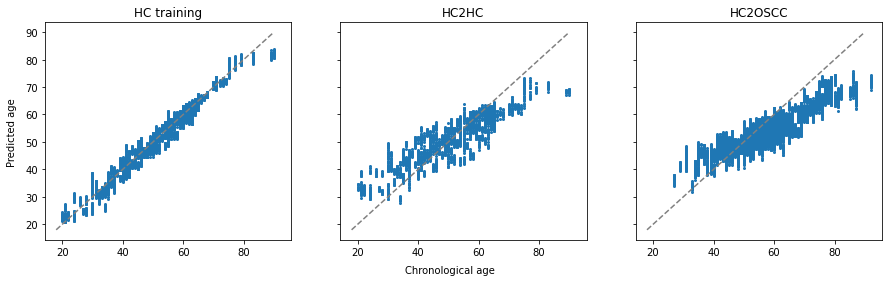

In [301]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), 
                         sharex=True, sharey=True)

axes[0].scatter(res_hc_train['Y_TRUE'], res_hc_train['Y_PRED_ADJ'], s=4)
axes[0].set_title('HC training')
axes[0].plot([18, 90], [18, 90], color='grey', linestyle='--')

axes[1].scatter(res_hc_test['Y_TRUE'], res_hc_test['Y_PRED_ADJ'], s=4)
axes[1].set_title('HC2HC')
axes[1].plot([18, 90], [18, 90], color='grey', linestyle='--')

axes[2].scatter(res_oscc['Y_TRUE'], res_oscc['Y_PRED_ADJ'], s=4)
axes[2].set_title('HC2OSCC')
axes[2].plot([18, 90], [18, 90], color='grey', linestyle='--')


fig.text(0.5, 0.01, 'Chronological age', ha='center')
fig.text(0.09, 0.5, 'Predicted age', va='center', rotation='vertical')

In [214]:
res_hc_train.head()

,CV,Y_PRED,Y_TRUE,delta,age_group_5y,delta_mean,Y_PRED_ADJ
sample-id,,,,,,,
SRR15560942,0,39.2310,35.0,4.2310,3>=5,6.065921,33.165079
SRR5559395,0,55.3685,56.0,-0.6315,5>=5,-1.728485,57.096985
SRR15305649,0,40.8420,35.0,5.8420,3>=5,6.065921,34.776079
SRR5559586,0,62.1905,71.0,-8.8095,7<5,-10.283625,72.474125
SRR5559689,0,53.9925,57.0,-3.0075,5>=5,-1.728485,55.720985


In [254]:
# concat results and save to one table
df = pd.DataFrame()
for res, label in zip([res_hc_train, res_hc_test, res_oscc],
                      ['train', 'HC2HC', 'HC2OSCC']):
    df_i = res.copy()
    df_i['label'] = label
    df = pd.concat([df, df_i])

fn = 'figures-and-tables/age-prediction-results.csv'
if exists(fn):
    print('file exists...')
else:
    df.to_csv(fn)

In [221]:
res_hc_train['CV'].value_counts().sort_index().tail()

45    238
46    238
47    238
48    239
49    239
Name: CV, dtype: int64

In [222]:
mae_hc_train = []
r2_hc_train = []
for i in res_hc_train['CV'].unique():
    df = res_hc_train.query('CV == %d' % i)
    v = metrics.mean_absolute_error(df['Y_TRUE'], df['Y_PRED_ADJ'])
    mae_hc_train.append(v)
    v = metrics.r2_score(df['Y_TRUE'], df['Y_PRED_ADJ'])
    r2_hc_train.append(v)

In [223]:
print("MAE(mean ± std.): %.4f ± %.4f" % (np.round(np.mean(mae_hc_train), 4), np.round(np.std(mae_hc_train), 4)))
print('R2(mean ± std.) : %.4f ± %.4f' % (np.round(np.mean(r2_hc_train), 4), np.round(np.std(r2_hc_train), 4)))

MAE(mean ± std.): 1.7610 ± 0.0720
R2(mean ± std.) : 0.9696 ± 0.0023


In [224]:
res_hc_test['CV'].value_counts().sort_index().tail()

45    60
46    60
47    60
48    59
49    59
Name: CV, dtype: int64

In [225]:
mae_hc_test = []
r2_hc_test = []
for i in res_hc_test['CV'].unique():
    df = res_hc_test.query('CV == %d' % i)
    v = metrics.mean_absolute_error(df['Y_TRUE'], df['Y_PRED_ADJ'])
    mae_hc_test.append(v)
    v = metrics.r2_score(df['Y_TRUE'], df['Y_PRED_ADJ'])
    r2_hc_test.append(v)

In [226]:
print("MAE : %.4f ± %.4f" % (np.round(np.mean(mae_hc_test), 4), np.round(np.std(mae_hc_test), 4)))
print('R2  : %.4f ± %.4f' % (np.round(np.mean(r2_hc_test), 4), np.round(np.std(r2_hc_test), 4)))

MAE : 5.1415 ± 0.5352
R2  : 0.7622 ± 0.0452


In [227]:
res_oscc['CV'].value_counts().sort_index().tail()

45    403
46    403
47    403
48    403
49    403
Name: CV, dtype: int64

In [228]:
mae_oscc = []
r2_oscc = []
for i in res_oscc['CV'].unique():
    df = res_oscc.query('CV == %d' % i)
    v = metrics.mean_absolute_error(df['Y_TRUE'], df['Y_PRED_ADJ'])
    mae_oscc.append(v)
    v = metrics.r2_score(df['Y_TRUE'], df['Y_PRED_ADJ'])
    r2_oscc.append(v)

In [229]:
print("MAE : %.4f ± %.4f" % (np.round(np.mean(mae_oscc), 4), np.round(np.std(mae_oscc), 4)))
print('R2  : %.4f ± %.4f' % (np.round(np.mean(r2_oscc), 4), np.round(np.std(r2_oscc), 4)))

MAE : 5.8176 ± 0.1705
R2  : 0.6432 ± 0.0227


## PRED-TRUE violin plot

In [297]:
pmt_train = res_hc_train['Y_PRED_ADJ'] - res_hc_train['Y_TRUE']
pmt_test = res_hc_test['Y_PRED_ADJ'] - res_hc_test['Y_TRUE'] 
pmt_oscc = res_oscc['Y_PRED_ADJ'] - res_oscc['Y_TRUE'] 

In [298]:
data = pd.DataFrame({'pmt': pd.concat([pmt_train, pmt_test, pmt_oscc]).values,
                     'group': ['Training'] * len(pmt_train) + ['HC2HC'] * len(pmt_test) + ['HC2OSCC'] * len(pmt_oscc)})

In [299]:
data.shape

(35050, 2)

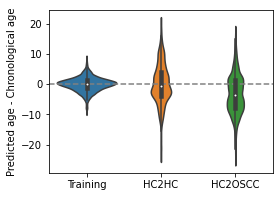

In [300]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.axhline(y=0, color='grey', linestyle='--')

sns.violinplot(x='group', y='pmt', data=data,
               ax=ax)

ax.set_ylabel('Predicted age - Chronological age')
ax.set_xlabel('')

In [306]:
data.head()

,pmt,group
0,-1.834921,Training
1,1.096985,Training
2,-0.223921,Training
3,1.474125,Training
4,-1.279015,Training


In [310]:
from scipy.stats import ttest_ind
from itertools import combinations

for a, b in combinations(data['group'].unique(), 2):
    print(a, 'vs', b, ":")
    print(ttest_ind(data.query('group == "%s"' % a)['pmt'], data.query('group == "%s"' % b)['pmt']))

Training vs HC2HC :
Ttest_indResult(statistic=-1.9331661730125256, pvalue=0.053234655520262686)
Training vs HC2OSCC :
Ttest_indResult(statistic=53.630100925868895, pvalue=0.0)
HC2HC vs HC2OSCC :
Ttest_indResult(statistic=27.05713622830059, pvalue=9.310160953342857e-159)
